# Requirement:

External library to import

In [102]:
import sys
sys.path.insert(0, './library/')
import zipfile
import os
import time
import pymongo as pym
import pandas as pd
import folium
import numpy as np
import requests
from shapely.geometry  import Polygon, LineString, asShape, mapping, Point
import math
import geopy
from shapely.geometry import Polygon, MultiPolygon, Point, mapping
from geopy.distance import vincenty,great_circle
from folium.plugins import FastMarkerCluster
from datetime import datetime
from geopy.distance import vincenty,great_circle

# Data:

1. gtfs file of the city. 
 ->[repository of gtfs file https://transitfeeds.com/]
2. pbf file of [openstreetmap](openstreetmap.org) extract from of the city/region of interest. ->[repository of osm extract: http://download.geofabrik.de/ -- https://mapzen.com/data/metro-extracts/]

# Url and paths  [**set it!**]
### mongodb settings

In [88]:
city = 'Budapest' # name of the city 
urlMongoDb = "mongodb://localhost:27017/"; # url of the mongodb database
client = pym.MongoClient(urlMongoDb)
gtfsDB = client['PublicTransportAnalysis']
#OPTIONAL
urlMongoDbPop = "mongodb://localhost:27017/"; # url of the mongodb database of population data
popDbName = "population"
popCollectionName = "europe"
popField = "pop"

### path of the gtfs files.

In [8]:
directoryGTFS = './gtfs/'+ city+ '/' # directory of the gtfs files.

### Settings of the date and the day for the computation of accessibility quantitites
the date must be in the interval of validity of the gtfs files, check it in the "calendar.txt" and "calendar_dates.txt" files inside the gtfs zip files.

In [9]:
from libConnections import printGtfsDate
printGtfsDate(directoryGTFS)

interval of validity of the gtfs files
gtfs.zip file
 calendar_dates.txt -> date:20170515 (first row)


In [10]:
day = "20170607" #hhhhmmdd
dayName = "wednesday" #name of the corresponding day

 ## Define url of the osrm server 

In [11]:
urlServerOsrm = 'http://localhost:5000/'; #url of the osrm server of the city

## Parameters thst define the resolution and extention of tesselletion and the maximum of the walking time

In [12]:
#grid step of the hexagonal tesselletion in kilometers
gridEdge = 0.4

#parameters of walking distance
timeWalk = 15 * 60 #seconds 
velocityWalk = 1.39 # m/s ***5km/h***
distanceS = timeWalk * velocityWalk

# Start of the computation

### Read stops, routes, trips, calendar and calendar_dates from gtfs

In [13]:
from libStopsPoints import loadGtfsFile
listOfFile = ['stops.txt','routes.txt','trips.txt', 'calendar.txt', 'calendar_dates.txt']#, 'stop_times.txt']#, 'shapes.txt']
loadGtfsFile(gtfsDB, directoryGTFS, city, listOfFile)

removing stops  of  Budapest
removing routes  of  Budapest
removing trips  of  Budapest
removing calendar  of  Budapest
removing calendar_dates  of  Budapest
gtfs.zip
stops.txt -> (7438,7438)
routes.txt -> (359,359)
trips.txt -> (203273,203273)
calendar_dates.txt -> (11590,11590)


## Fill the datatbase with the connections

#### Fill the database with the connections

In [14]:
from libConnections import readConnections
readConnections(gtfsDB, city, directoryGTFS, day, dayName)

number of file in calendar+calendar_dates: 1
in stops: 1

Checking the number of services active in the date selected:
file: gtfs.zip 	 total number of active service (in calendar.txt): Serv NOT FOUND!!
number of different service_id: 0


file: gtfs.zip 	 total number of active service (in calendar_dates.txt): 249
number of different service_id: 1 total number of active services found: 249
number of trips 203000
 gtfs.zip
reading stop_times.txt...
readed... converting to a list
converted...
inserting to DB....170, err 0, err_start 0, err_start_after 0
tot connections 757002


## remove stops with no connections and label with the pos field

In [15]:
from libStopsPoints import removingStopsNoConnections, setPosField
removingStopsNoConnections(gtfsDB, city)
setPosField(gtfsDB, city)

In [16]:
from libConnections import updateConnectionsStopName
updateConnectionsStopName(gtfsDB, city)

connections deleted 07002 pEnd 757002, totC 757002


# Tassel with exagons

## Read list of stops from file

In [262]:
from libStopsPoints import returnStopsList
stopsList = returnStopsList(gtfsDB, city)

tot stop 5346  stop error : 0


## Compute the box that include all stops
The edge of such box are enlarged by distanceS.

In [263]:
from libStopsPoints import boundingBoxStops, mapStops
from IPython.core.display import display, HTML
display(HTML('<h1>All stops of the public transport present in the gtfs files</h1>'))
bbox = boundingBoxStops(stopsList)
mapStops(bbox, stopsList)

## Tassel the box with exagons.

In [19]:
from libHex import hexagonalGrid
hexBin, pointBin = hexagonalGrid(bbox, gridEdge, gtfsDB['stops'], distanceS, city)

In [22]:
from libHex import insertPoints
insertPoints(pointBin, city, gtfsDB)
print('total number of hexagons created : {0}'.format(gtfsDB['points'].find({'city':city}).count()))

total number of hexagons created : 7613


In [21]:
from libHex import unionHexs
from IPython.core.display import display, HTML
display(HTML('<h1>First tesselletion of the area served by public transport</h1>'))
latlon = list(reversed(gtfsDB['points'].find_one({'city':city})['point']['coordinates']))
map_osm = folium.Map(location=latlon, zoom_start=9);
map_osm.choropleth(unionHexs(pointBin),  fill_color='#3288bd',fill_opacity=0.3, line_color='#3288bd',line_weight=2, line_opacity=1)
map_osm

## Find the hex with walkingTime less than timeWalk from a stops

In [23]:
from libHex import pointsServed
pointsServed(gtfsDB, stopsList, urlServerOsrm, distanceS, timeWalk, city)

In [24]:
print("Number of hexagons: {0}".format(gtfsDB['points'].find({'served':True, 'city':city}).count()))

Number of hexagons: 6123


## Setting field "pos" for points for performance

In [27]:
from libHex import settingHexsPos
settingHexsPos(gtfsDB, city)

In [52]:
from libHex import showHexs
from IPython.core.display import display, HTML
display(HTML('<h1>Tesselletion of the area served by the public transport</h1>'))
showHexs(gtfsDB, city, 10)

## Setting Population of Hexagons

In [31]:
from libHex import setHexsPop 

if urlMongoDbPop != "" and popCollectionName != "":
    clientPop = pym.MongoClient(urlMongoDbPop)
    popDb = clientPop[popDbName]
    popCollection = popDb[popCollectionName]
    setHexsPop(gtfsDB, popCollection, popField, city)
else:
    print("Population NOT INSERTED!")

res = gtfsDB['points'].update_many({'pop':{'$exists':False}}, {'$set':{'pop':0}})
print("n° of matched hexagons with population Polygons: {0} \n \
not matched: {1} (setted to zero)".format(gtfsDB['points'].find({'pop':{'$exists':True}}).count(),
                                                                                     res.modified_count))

n° of matched hexagons with population Polygons: 12959 
 not matched: 0 (setted to zero)


# Adding the walking time between stops and points

In [55]:
from libStopsPoints import computeNeigh
computeNeigh(gtfsDB, urlServerOsrm, distanceS, timeWalk,  city)

# Compute quantities and observable

TimeList is the list of starting time for computing the isochrones

In [33]:
timeList = list(range(0,24,2))#[7,10,13,16,19,22] # List of starting time for computing the isochrones
timeList = [7,10,13,16,19,22] # List of starting time for computing the isochrones
hStart = timeList[0]*3600

### List of connections

In [8]:
from libConnections import makeArrayConnections
arrayCC = makeArrayConnections(gtfsDB, hStart, city)

Num of connection 757002, 123780, 4489, 4515]


### List of list of the points and stops neighbors

In [9]:
from libStopsPoints import listPointsStopsN 
arraySP = listPointsStopsN(gtfsDB, city)

## Compute accessibility quantities

In [ ]:
import imp
import icsa
import libAccessibility
imp.reload(libAccessibility)
from icsa import computeAccessibilities
imp.reload(icsa)
listAccessibility = ['velocityScore','socialityScore', 'velocityScoreGall', 
                     'socialityScoreGall','velocityScore1h', 'socialityScore1h',
                    'timeVelocity', 'timeSociality']
computeIsochrone = False
if 'isochrones' in gtfsDB.collection_names():
    #gtfsDB['isochrones'].delete_many({'city':city})
    pass
for timeStart in timeList:
    timeStart *= 3600
    print( 'Time Isochrone Start: {0}'.format(timeStart/3600,))
    computeAccessibilities(city, timeStart, arrayCC, arraySP, gtfsDB, computeIsochrone, timeStart/3600 == timeList[0], listAccessibility=listAccessibility)

## Compute averages of the accessiblity quantities computed

In [170]:
import libStopsPoints
imp.reload(libStopsPoints)
from libStopsPoints import computeAverage
computeAverage(listAccessibility, gtfsDB, city)

# RESULTS

## maps

In [38]:
from libHex import reduceGeojsonInShellSubField  
from IPython.core.display import display, HTML

field1 = 'velocityScore'
field2 = 'avg'
color = ['#993404', "#f16913", "#fdae6b", '#74c476', '#31a354', '#006d2c', "#6baed6", "#4292c6", "#2171b5", '#08519c', '#f768a1', '#dd3497', '#ae017e', '#49006a'];
shell = [0., 2., 4., 5, 6., 7, 8., 9, 10., 11, 12., 13, 15, 17.];
print ("number of hexs in total", gtfsDB['points'].find({field1:{'$exists':True}, 'city':city}).count())
res = reduceGeojsonInShellSubField(list(gtfsDB['points'].find({'city':city})), field1, field2, color, shell)
#res = showMapHexRedux(city, gtfsDB['points'], field = field, shell = shell, save=True)

display(HTML('<h1>Velocity Score</h1>'))

res[1]

number of hexs in total 6123
shell 0.0-2.0 -> 123 hexs
shell 2.0-4.0 -> 2075 hexs
shell 4.0-5 -> 1294 hexs
shell 5-6.0 -> 1307 hexs
shell 6.0-7 -> 948 hexs
shell 7-8.0 -> 305 hexs
shell 8.0-9 -> 66 hexs
shell 9-10.0 -> 5 hexs


In [39]:
from libHex import reduceGeojsonInShellSubField  
from IPython.core.display import display, HTML

field1 = 'socialityScore'
field2 = 'avg'
color = ["#000000","rgb(95, 95, 95)","rgb(180, 180, 180)","rgb(8, 48, 107)","rgb(15, 87, 159)","rgb(47, 126, 188)","rgb(109, 174, 213)","rgb(181, 212, 233)","rgb(253, 202, 148)",
"rgb(253, 176, 122)","rgb(250, 142, 93)","rgb(241, 108, 73)","rgb(224, 69, 48)","rgb(243, 105, 163)","rgb(224, 62, 152)","rgb(153, 3, 124)","rgb(73, 0, 106)"]
shell = [0, 50000, 100000, 200000, 300000, 400000, 500000, 600000,700000,800000, 900000, 1000000,1500000, 2000000,2500000, 3000000];
print ("number of hexs in total", gtfsDB['points'].find({field1:{'$exists':True}, 'city':city}).count())
res = reduceGeojsonInShellSubField(list(gtfsDB['points'].find({'city':city})), field1, field2, color, shell)
#res = showMapHexRedux(city, gtfsDB['points'], field = field, shell = shell, save=True)

display(HTML('<h1>Sociality Score</h1>'))

res[1]

number of hexs in total 6123
shell 0-50000 -> 443 hexs
shell 50000-100000 -> 753 hexs
shell 100000-200000 -> 1255 hexs
shell 200000-300000 -> 1489 hexs
shell 300000-400000 -> 1040 hexs
shell 400000-500000 -> 635 hexs
shell 500000-600000 -> 344 hexs
shell 600000-700000 -> 144 hexs
shell 700000-800000 -> 20 hexs


# Compute average time distance from the center
Computing the average time distance from the center of the city. 
We consider two center: 
1. where the velocityScore is max
2. Where the socialityScore is max.

In [114]:
from libConnections import makeArrayConnections
from libStopsPoints import listPointsStopsN 
from libHex import reduceGeojsonInShell  
from icsa import coumputeAvgTimeDistance

startPoint = gtfsDB['points'].find({'city':city},sort=[('velocityScore.avg',-1)])[0]

if 'arrayCC' not in locals():
    arrayCC = makeArrayConnections(gtfsDB, 0, city)
if 'arraySP' not in locals():
    arraySP = listPointsStopsN(gtfsDB, city)

timeListSec = [x*3600. for x in timeList]
timeDist = coumputeAvgTimeDistance(startPointVel, timeListSec, arrayCC, arraySP, gtfsDB, city)
startPointLatLon = [startPoint['point']["coordinates"][1], startPoint['point']["coordinates"][0]]
for pos, tDist in enumerate(timeDist):
    pointSelectedLonLat = gtfsDB["points"].find_one({'pos':pos, "city":city})["point"]["coordinates"]
    sVelDist = vincenty(startPointLatLon,(pointSelectedLonLat[1], pointSelectedLonLat[0])).meters #dist in meter 
    gtfsDB["points"].update_one({'pos':pos, 'city':city},{'$set':{'tVelDist':tDist, "sVelDist":sVelDist} })
timeDist
pointsList = list(gtfsDB['points'].find({'city':city},{'pointN':0, 'stopN':0}))
res = reduceGeojsonInShell(pointsList,'tVelDist')
res[1]

In [59]:
startPoint = gtfsDB['points'].find({'city':city},sort=[('socialityScore.avg',-1)])[0]

if 'arrayCC' not in locals():
    arrayCC = makeArrayConnections(gtfsDB, 0, city)
if 'arraySP' not in locals():
    arraySP = listPointsStopsN(gtfsDB, city)

timeListSec = [x*3600. for x in timeList]
timeDist = coumputeAvgTimeDistance(startPoint, timeListSec, arrayCC, arraySP, gtfsDB, city)
for pos, tDist in enumerate(timeDist):
    gtfsDB["points"].update_one({'pos':pos, 'city':city},{'$set':{'tSocDist':tDist}})
timeDist
pointsList = list(gtfsDB['points'].find({'city':city},{'pointN':0, 'stopN':0}))
res = reduceGeojsonInShell(pointsList,'tSocDist')
res[1]

## Analisys Exponential Decay of accessibility the quantities

### Velocity Score and Sociality score vs time distance from the center

 1. fitting function:
     $ae^{-bx}$
 2. fitting function:
     $ae^{-bx^2}$
 3. fitting function:
     $\text{maxValue} * e^{-bx^a}$

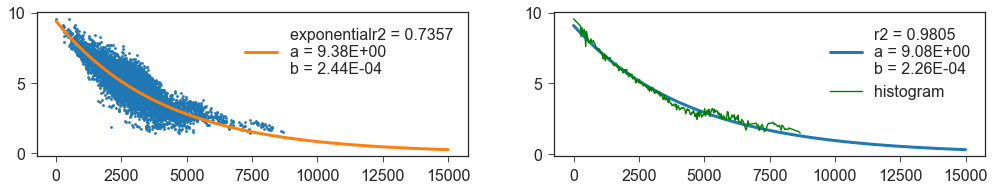

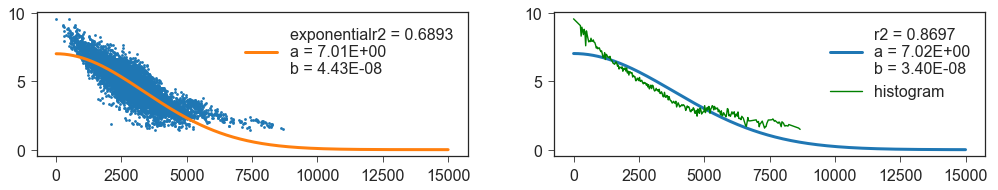

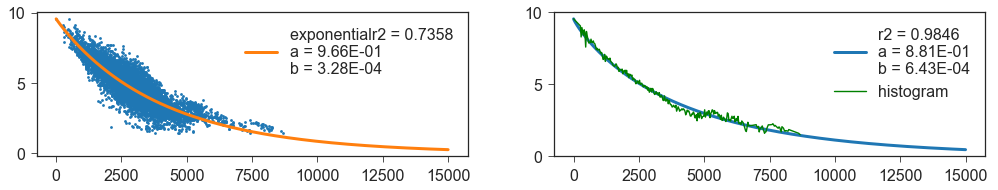

In [252]:
imp.reload(libAnalysis)
from libAnalysis import fitAndPlot, expon, gauss, giveVarExpon

maxValue = gtfsDB['points'].find({'city':city}, sort=[(('velocityScore.avg',-1))])[0]["velocityScore"]["avg"]
functVarExp =  giveVarExpon(maxValue)
fitAndPlot('velocityScore','tVelDist', gtfsDB, city, expon, p0 = [12,0.0001], nameFunc = "exponential")
fitAndPlot('velocityScore','tVelDist', gtfsDB, city, gauss, p0 = [12,0.000001], nameFunc = "exponential")
fitAndPlot('velocityScore','tVelDist', gtfsDB, city, functVarExp, p0 = [1,0.0001], nameFunc = "exponential");

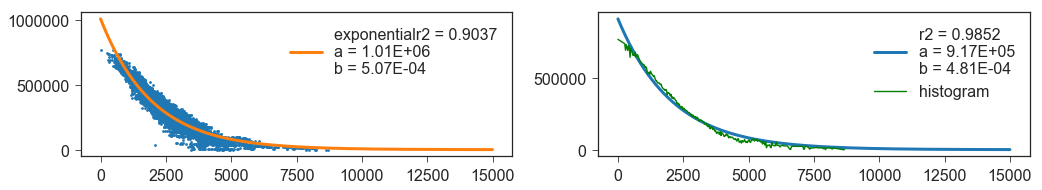

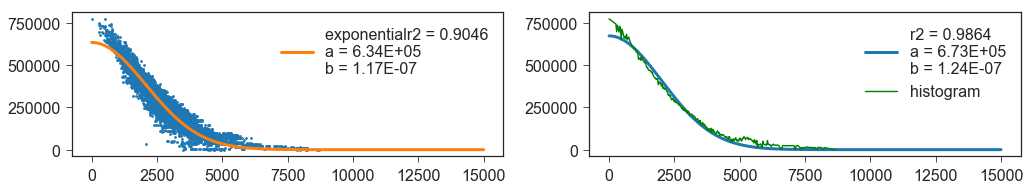

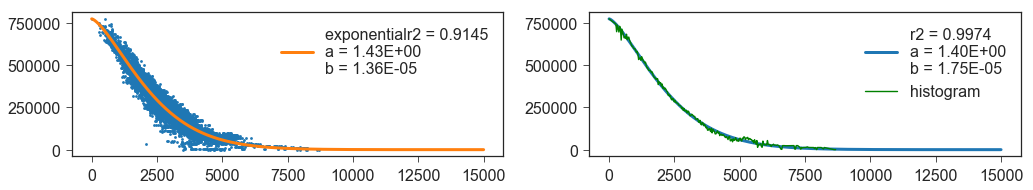

In [260]:
imp.reload(libAnalysis)
from libAnalysis import fitAndPlot, expon, gauss, giveVarExpon

quantity = "socialityScore"
distField = "tSocDist"
maxValue = gtfsDB['points'].find({'city':city}, sort=[((quantity+'.avg',-1))])[0][quantity]["avg"]
functVarExp =  giveVarExpon(maxValue)
fitAndPlot(quantity,distField, gtfsDB, city, expon, p0 = [100000,0.0001], nameFunc = "exponential")
fitAndPlot(quantity,distField, gtfsDB, city, gauss, p0 = [100000,0.0000001], nameFunc = "gauss")
fitAndPlot(quantity,distField, gtfsDB, city, functVarExp, p0 = [1,0.001], nameFunc = "Vary Exp");

# Saving File

In [190]:
import saveData
imp.reload(saveData)
from saveData import makeZipCitychrone
if 'arrayCC' in locals():
    makeZipCitychrone(city, gtfsDB, arrayCC, newScenario=True, urlServerOsrm=urlServerOsrm)
else:
    makeZipCitychrone(city, gtfsDB, newScenario=True)